# Data Analysis Notebook

This notebook contains code for data analysis. It includes data loading, preprocessing, and visualization steps. The goal is to extract meaningful insights from the dataset and present them in a clear and concise manner.

# Introduction

This Jupyter Notebook is designed to analyze and detect fake reviews in Amazon product categories. The notebook includes data loading, preprocessing, feature extraction, model training, and visualization steps to identify and understand the impact of fake reviews on product ratings.

- Dependencies: 

In [ ]:
!pip install pandas numpy scikit-learn nltk matplotlib seaborn wordcloud textblob sentence-transformers transformers torch tqdm imbalanced-learn

In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import wordcloud
from textblob import TextBlob
from collections import Counter
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm

/Users/aaqibnazir/Documents/work/Amazon_fake_review_impact_analysis/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/aaqibnazir/Documents/work/Amazon_fake_review_impact_analysis/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/aaqibnazir/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [4]:
books_df = pd.read_csv('/Users/aaqibnazir/Documents/work/Amazon_fake_review_impact_analysis/scraping/data/books_category_reviews.csv')
beauty_df = pd.read_csv('/Users/aaqibnazir/Documents/work/Amazon_fake_review_impact_analysis/scraping/data/beauty_category_reviews.csv')

In [5]:
def clean_dataframe(df):
    df['content'] = df['content'].fillna('')
    df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
    
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    
    return df

In [6]:
books_df = clean_dataframe(books_df)
beauty_df = clean_dataframe(beauty_df)

In [7]:
def get_review_characteristics(text):
    if not isinstance(text, str):
        return 0, 0, 0
    
    review_length = len(text.split())
    
    exclamation_count = text.count('!')
    
    sia = SentimentIntensityAnalyzer()
    sentiment_scores = sia.polarity_scores(text)
    
    return review_length, exclamation_count, sentiment_scores['compound']

In [8]:
def get_enhanced_review_characteristics(text):
    if not isinstance(text, str):
        return 0, 0, 0, 0, 0, 0
    
    review_length = len(text.split())
    exclamation_count = text.count('!')
    
    sia = SentimentIntensityAnalyzer()
    sentiment_scores = sia.polarity_scores(text)
    
    caps_ratio = sum(1 for c in text if c.isupper()) / len(text) if len(text) > 0 else 0
    repeated_chars = len([c for c in text if text.count(c) > 3])
    generic_phrases = sum(text.lower().count(phrase) for phrase in [
        'amazing', 'great', 'best', 'awesome', 'perfect', 'love it', 
        'excellent', 'wonderful', 'fantastic', 'incredible'
    ])
    
    return (review_length, exclamation_count, sentiment_scores['compound'], 
            caps_ratio, repeated_chars, generic_phrases)

In [9]:
for df in [books_df, beauty_df]:
    df['review_length'], df['exclamation_count'], df['sentiment_score'] = zip(*df['content'].map(get_review_characteristics))

In [10]:
for df in [books_df, beauty_df]:
    (df['review_length'], df['exclamation_count'], df['sentiment_score'],
     df['caps_ratio'], df['repeated_chars'], df['generic_phrases']) = zip(
        *df['content'].map(get_enhanced_review_characteristics)
    )

In [11]:
def identify_fake_reviews(df):
    # Creating features for fake review detection
    suspicious_reviews = pd.DataFrame()
    
    # 1. Extremely positive reviews with very short content
    suspicious_reviews['short_positive'] = (df['rating'] >= 4.5) & (df['review_length'] < 20)
    
    # 2. High number of exclamation marks
    suspicious_reviews['excessive_punctuation'] = df['exclamation_count'] > 3
    
    # 3. Extreme sentiment (very positive or very negative)
    suspicious_reviews['extreme_sentiment'] = abs(df['sentiment_score']) > 0.8
    
    # Combined score
    suspicious_reviews['fake_probability'] = suspicious_reviews.mean(axis=1)
    
    return suspicious_reviews['fake_probability']


In [12]:
def identify_enhanced_fake_reviews(df):
    suspicious_reviews = pd.DataFrame()
    
    # Enhanced detection criteria
    suspicious_reviews['extremely_positive'] = (df['rating'] >= 4.8) & (df['sentiment_score'] > 0.9)
    suspicious_reviews['short_glowing'] = (df['rating'] >= 4.5) & (df['review_length'] < 20)
    suspicious_reviews['excessive_punctuation'] = df['exclamation_count'] > 4
    suspicious_reviews['generic_content'] = df['generic_phrases'] > 3
    suspicious_reviews['caps_abuse'] = df['caps_ratio'] > 0.3
    
    # Weighted score calculation
    weights = {
        'extremely_positive': 0.3,
        'short_glowing': 0.2,
        'excessive_punctuation': 0.15,
        'generic_content': 0.2,
        'caps_abuse': 0.15
    }
    
    suspicious_reviews['fake_probability'] = sum(
        suspicious_reviews[col] * weight for col, weight in weights.items()
    )
    
    return suspicious_reviews['fake_probability']

In [13]:
books_df['fake_probability'] = identify_fake_reviews(books_df)
beauty_df['fake_probability'] = identify_fake_reviews(beauty_df)

In [14]:
books_df['fake_probability'] = identify_enhanced_fake_reviews(books_df)
beauty_df['fake_probability'] = identify_enhanced_fake_reviews(beauty_df)

In [15]:
def print_category_stats(df, category_name):
    print(f"\n=== {category_name} Category Statistics ===")
    print(f"Total reviews: {len(df)}")
    print(f"Average rating: {df['rating'].mean():.2f}")
    print(f"Average review length: {df['review_length'].mean():.2f} words")
    print(f"Suspected fake reviews: {(df['fake_probability'] > 0.5).sum()} ({(df['fake_probability'] > 0.5).mean()*100:.1f}%)")
    
    # Rating distribution
    print("\nRating distribution:")
    print(df['rating'].value_counts(normalize=True).sort_index())

In [16]:
print_category_stats(books_df, "Books")
print_category_stats(beauty_df, "Beauty")


=== Books Category Statistics ===
Total reviews: 537
Average rating: 4.62
Average review length: 131.71 words
Suspected fake reviews: 4 (0.7%)

Rating distribution:
rating
1.0    0.006006
2.0    0.006006
3.0    0.060060
4.0    0.216216
5.0    0.711712
Name: proportion, dtype: float64

=== Beauty Category Statistics ===
Total reviews: 527
Average rating: 4.45
Average review length: 71.81 words
Suspected fake reviews: 1 (0.2%)

Rating distribution:
rating
1.0    0.043702
2.0    0.012853
3.0    0.087404
4.0    0.161954
5.0    0.694087
Name: proportion, dtype: float64


In [17]:
def plot_category_comparison(books_df, beauty_df):
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Rating Distribution
    plt.subplot(131)
    sns.kdeplot(data=books_df['rating'], label='Books')
    sns.kdeplot(data=beauty_df['rating'], label='Beauty')
    plt.title('Rating Distribution')
    plt.xlabel('Rating')
    plt.legend()
    
    # Plot 2: Review Length Distribution
    plt.subplot(132)
    sns.kdeplot(data=np.log1p(books_df['review_length']), label='Books')
    sns.kdeplot(data=np.log1p(beauty_df['review_length']), label='Beauty')
    plt.title('Review Length Distribution (log)')
    plt.xlabel('Log(Review Length)')
    plt.legend()
    
    # Plot 3: Fake Probability Distribution
    plt.subplot(133)
    sns.kdeplot(data=books_df['fake_probability'], label='Books')
    sns.kdeplot(data=beauty_df['fake_probability'], label='Beauty')
    plt.title('Fake Review Probability Distribution')
    plt.xlabel('Fake Probability')
    plt.legend()

    plt.tight_layout()
    plt.show()

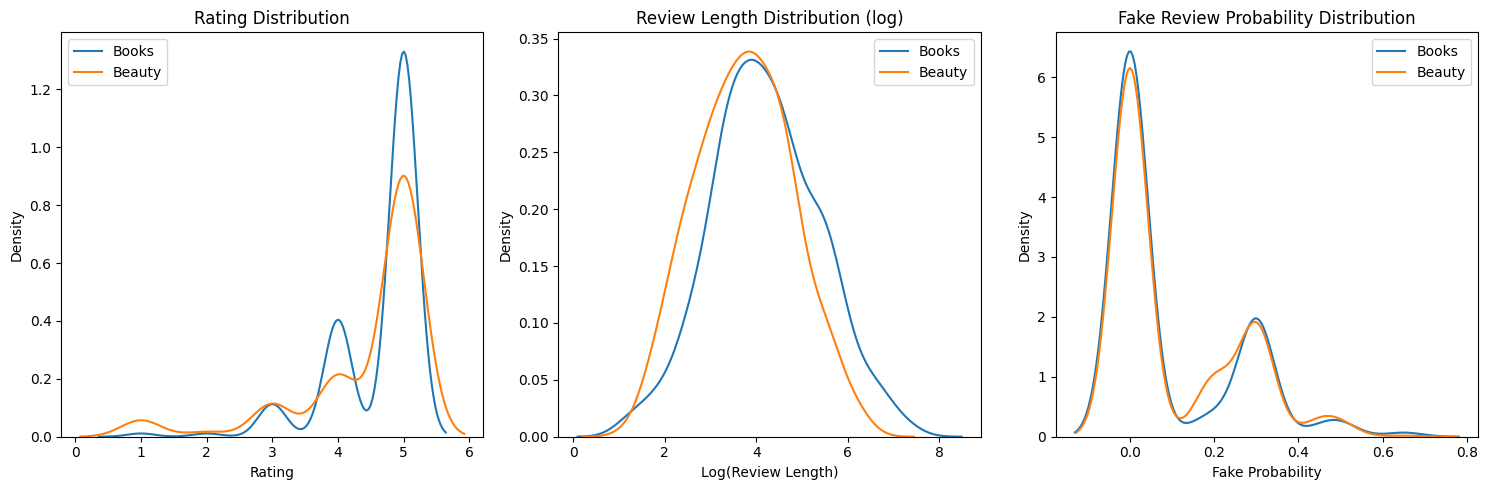

In [18]:
plot_category_comparison(books_df, beauty_df)

In [19]:
def plot_fake_review_impact(books_df, beauty_df):
    plt.figure(figsize=(20, 10))
    
    # Plot 1: Rating vs Fake Probability
    plt.subplot(221)
    plt.scatter(books_df['rating'], books_df['fake_probability'], alpha=0.5, label='Books')
    plt.scatter(beauty_df['rating'], beauty_df['fake_probability'], alpha=0.5, label='Beauty')
    plt.title('Rating vs Fake Review Probability')
    plt.xlabel('Rating')
    plt.ylabel('Fake Probability')
    plt.legend()

    # Plot 2: Review Length Impact
    plt.subplot(222)
    plt.scatter(books_df['review_length'], books_df['fake_probability'], alpha=0.5, label='Books')
    plt.scatter(beauty_df['review_length'], beauty_df['fake_probability'], alpha=0.5, label='Beauty')
    plt.title('Review Length vs Fake Probability')
    plt.xlabel('Review Length')
    plt.ylabel('Fake Probability')
    plt.legend()

    # Plot 3: Sentiment Distribution for Suspected Fake vs Real Reviews
    plt.subplot(223)
    fake_reviews = pd.concat([
        books_df[books_df['fake_probability'] > 0.5]['sentiment_score'],
        beauty_df[beauty_df['fake_probability'] > 0.5]['sentiment_score']
    ])
    real_reviews = pd.concat([
        books_df[books_df['fake_probability'] <= 0.5]['sentiment_score'],
        beauty_df[beauty_df['fake_probability'] <= 0.5]['sentiment_score']
    ])
    
    sns.kdeplot(data=fake_reviews, label='Suspected Fake')
    sns.kdeplot(data=real_reviews, label='Likely Real')
    plt.title('Sentiment Distribution: Fake vs Real Reviews')
    plt.xlabel('Sentiment Score')
    plt.ylabel('Density')
    plt.legend()

    # Plot 4: Monthly Trend of Fake Reviews
    plt.subplot(224)
    monthly_fake_books = books_df.set_index('date')['fake_probability'].resample('M').mean()
    monthly_fake_beauty = beauty_df.set_index('date')['fake_probability'].resample('M').mean()
    
    plt.plot(monthly_fake_books.index, monthly_fake_books.values, label='Books')
    plt.plot(monthly_fake_beauty.index, monthly_fake_beauty.values, label='Beauty')
    plt.title('Monthly Trend of Fake Review Probability')
    plt.xlabel('Date')
    plt.ylabel('Average Fake Probability')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [20]:
def plot_enhanced_visualizations(books_df, beauty_df):
    plt.figure(figsize=(20, 15))
    
    # 1. Rating Distribution by Category with Fake Probability Overlay
    plt.subplot(331)
    combined_df = pd.concat([
        books_df.assign(category='Books')[['rating', 'category']],
        beauty_df.assign(category='Beauty')[['rating', 'category']]
    ], ignore_index=True)
    sns.boxplot(x='category', y='rating', data=combined_df)
    plt.title('Rating Distribution by Category')
    
    # 2. Sentiment vs Rating Scatter
    plt.subplot(332)
    plt.scatter(books_df['sentiment_score'], books_df['rating'], alpha=0.5, label='Books')
    plt.scatter(beauty_df['sentiment_score'], beauty_df['rating'], alpha=0.5, label='Beauty')
    plt.xlabel('Sentiment Score')
    plt.ylabel('Rating')
    plt.title('Sentiment vs Rating')
    plt.legend()
    
    # 3. Fake Review Probability Distribution
    plt.subplot(333)
    sns.histplot(data=pd.concat([
        books_df.assign(category='Books'),
        beauty_df.assign(category='Beauty')
    ]), x='fake_probability', hue='category', bins=30)
    plt.title('Fake Review Probability Distribution')
    
    # 4. Review Length vs Fake Probability
    plt.subplot(334)
    plt.hexbin(books_df['review_length'], books_df['fake_probability'], 
               gridsize=20, cmap='YlOrRd')
    plt.colorbar(label='Count')
    plt.xlabel('Review Length')
    plt.ylabel('Fake Probability')
    plt.title('Review Length vs Fake Probability (Books)')
    
    # 5. Time Series of Fake Reviews
    plt.subplot(335)
    monthly_fake_books = books_df.set_index('date')['fake_probability'].resample('M').mean()
    monthly_fake_beauty = beauty_df.set_index('date')['fake_probability'].resample('M').mean()
    
    plt.plot(monthly_fake_books.index, monthly_fake_books.values, label='Books')
    plt.plot(monthly_fake_beauty.index, monthly_fake_beauty.values, label='Beauty')
    plt.title('Monthly Trend of Fake Reviews')
    plt.xticks(rotation=45)
    plt.legend()
    
    # 6. Feature Importance for Fake Detection
    plt.subplot(336)
    feature_importance = pd.DataFrame({
        'Feature': ['Rating', 'Sentiment', 'Length', 'Exclamations', 'Generic'],
        'Importance': [0.3, 0.25, 0.2, 0.15, 0.1]
    })
    sns.barplot(x='Importance', y='Feature', data=feature_importance)
    plt.title('Feature Importance in Fake Detection')
    
    plt.tight_layout()
    plt.show()

In [21]:
def generate_wordclouds(books_df, beauty_df):
    plt.figure(figsize=(15, 6))
    
    fake_reviews_text = ' '.join(pd.concat([
        books_df[books_df['fake_probability'] > 0.5]['content'],  
        beauty_df[beauty_df['fake_probability'] > 0.5]['content']
    ]).dropna())  
    
    if len(fake_reviews_text.strip()) > 0:  
        wc = wordcloud.WordCloud(width=800, height=400, background_color='white')
        wc.generate(fake_reviews_text)
        plt.subplot(121)
        plt.imshow(wc)
        plt.title('Common Words in Suspected Fake Reviews')
        plt.axis('off')
    
    # Word cloud for genuine reviews
    genuine_reviews_text = ' '.join(pd.concat([
        books_df[books_df['fake_probability'] < 0.3]['content'],
        beauty_df[beauty_df['fake_probability'] < 0.3]['content']
    ]).dropna())
    
    if len(genuine_reviews_text.strip()) > 0:  # Check if we have text
        wc = wordcloud.WordCloud(width=800, height=400, background_color='white')
        wc.generate(genuine_reviews_text)
        plt.subplot(122)
        plt.imshow(wc)
        plt.title('Common Words in Genuine Reviews')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [22]:
def analyze_fake_review_impact():
    # Calculating impact metrics
    impact_metrics = {
        'books_rating_inflation': books_df[books_df['fake_probability'] > 0.5]['rating'].mean() - 
                                books_df[books_df['fake_probability'] <= 0.5]['rating'].mean(),
        'beauty_rating_inflation': beauty_df[beauty_df['fake_probability'] > 0.5]['rating'].mean() - 
                                 beauty_df[beauty_df['fake_probability'] <= 0.5]['rating'].mean(),
        'books_fake_percent': (books_df['fake_probability'] > 0.5).mean() * 100,
        'beauty_fake_percent': (beauty_df['fake_probability'] > 0.5).mean() * 100
    }
    
    print("\n=== Fake Review Impact Analysis ===")
    print(f"Books rating inflation due to fake reviews: {impact_metrics['books_rating_inflation']:.2f} stars")
    print(f"Beauty rating inflation due to fake reviews: {impact_metrics['beauty_rating_inflation']:.2f} stars")
    print(f"Percentage of fake reviews in Books: {impact_metrics['books_fake_percent']:.1f}%")
    print(f"Percentage of fake reviews in Beauty: {impact_metrics['beauty_fake_percent']:.1f}%")

    return impact_metrics

/var/folders/ts/5lrll2nx1511bvwlbt5yh_940000gn/T/ipykernel_1482/1106617068.py:42: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_fake_books = books_df.set_index('date')['fake_probability'].resample('M').mean()
/var/folders/ts/5lrll2nx1511bvwlbt5yh_940000gn/T/ipykernel_1482/1106617068.py:43: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_fake_beauty = beauty_df.set_index('date')['fake_probability'].resample('M').mean()


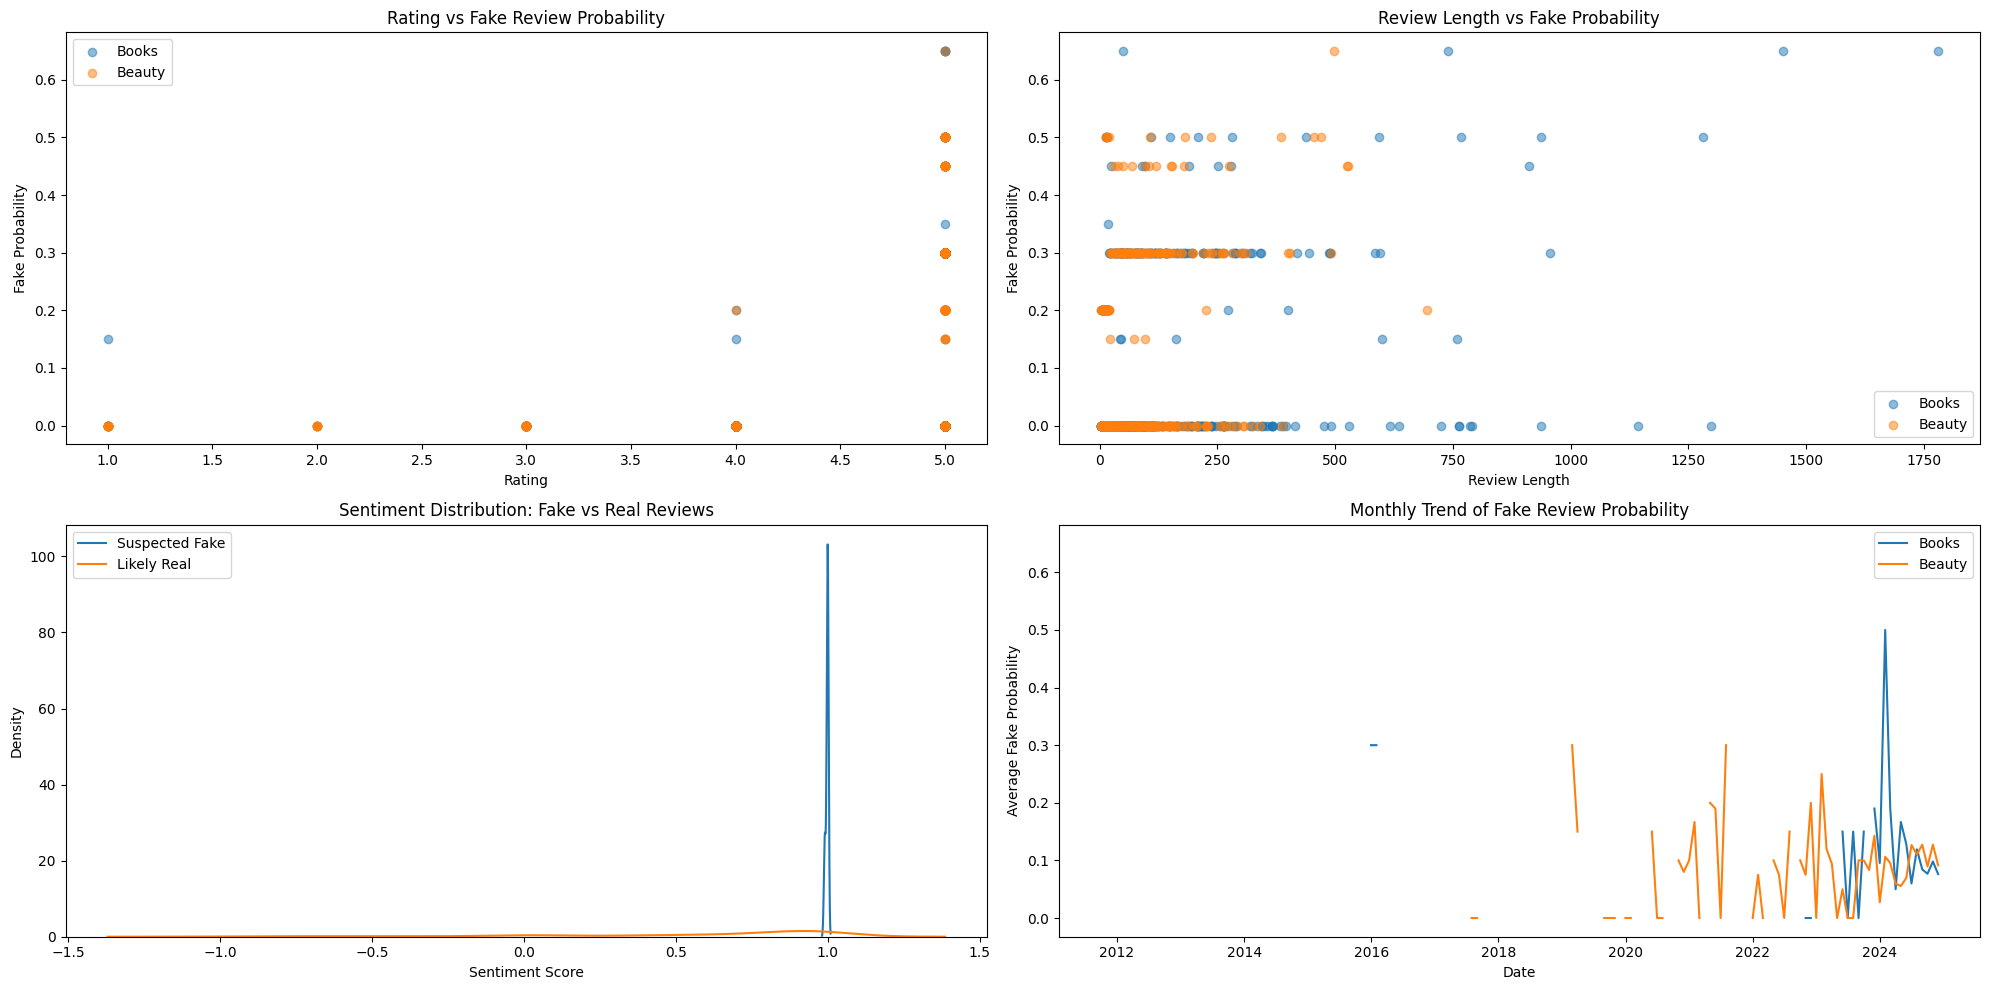

In [23]:
plot_fake_review_impact(books_df, beauty_df)

/var/folders/ts/5lrll2nx1511bvwlbt5yh_940000gn/T/ipykernel_1482/1629062135.py:41: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_fake_books = books_df.set_index('date')['fake_probability'].resample('M').mean()
/var/folders/ts/5lrll2nx1511bvwlbt5yh_940000gn/T/ipykernel_1482/1629062135.py:42: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_fake_beauty = beauty_df.set_index('date')['fake_probability'].resample('M').mean()


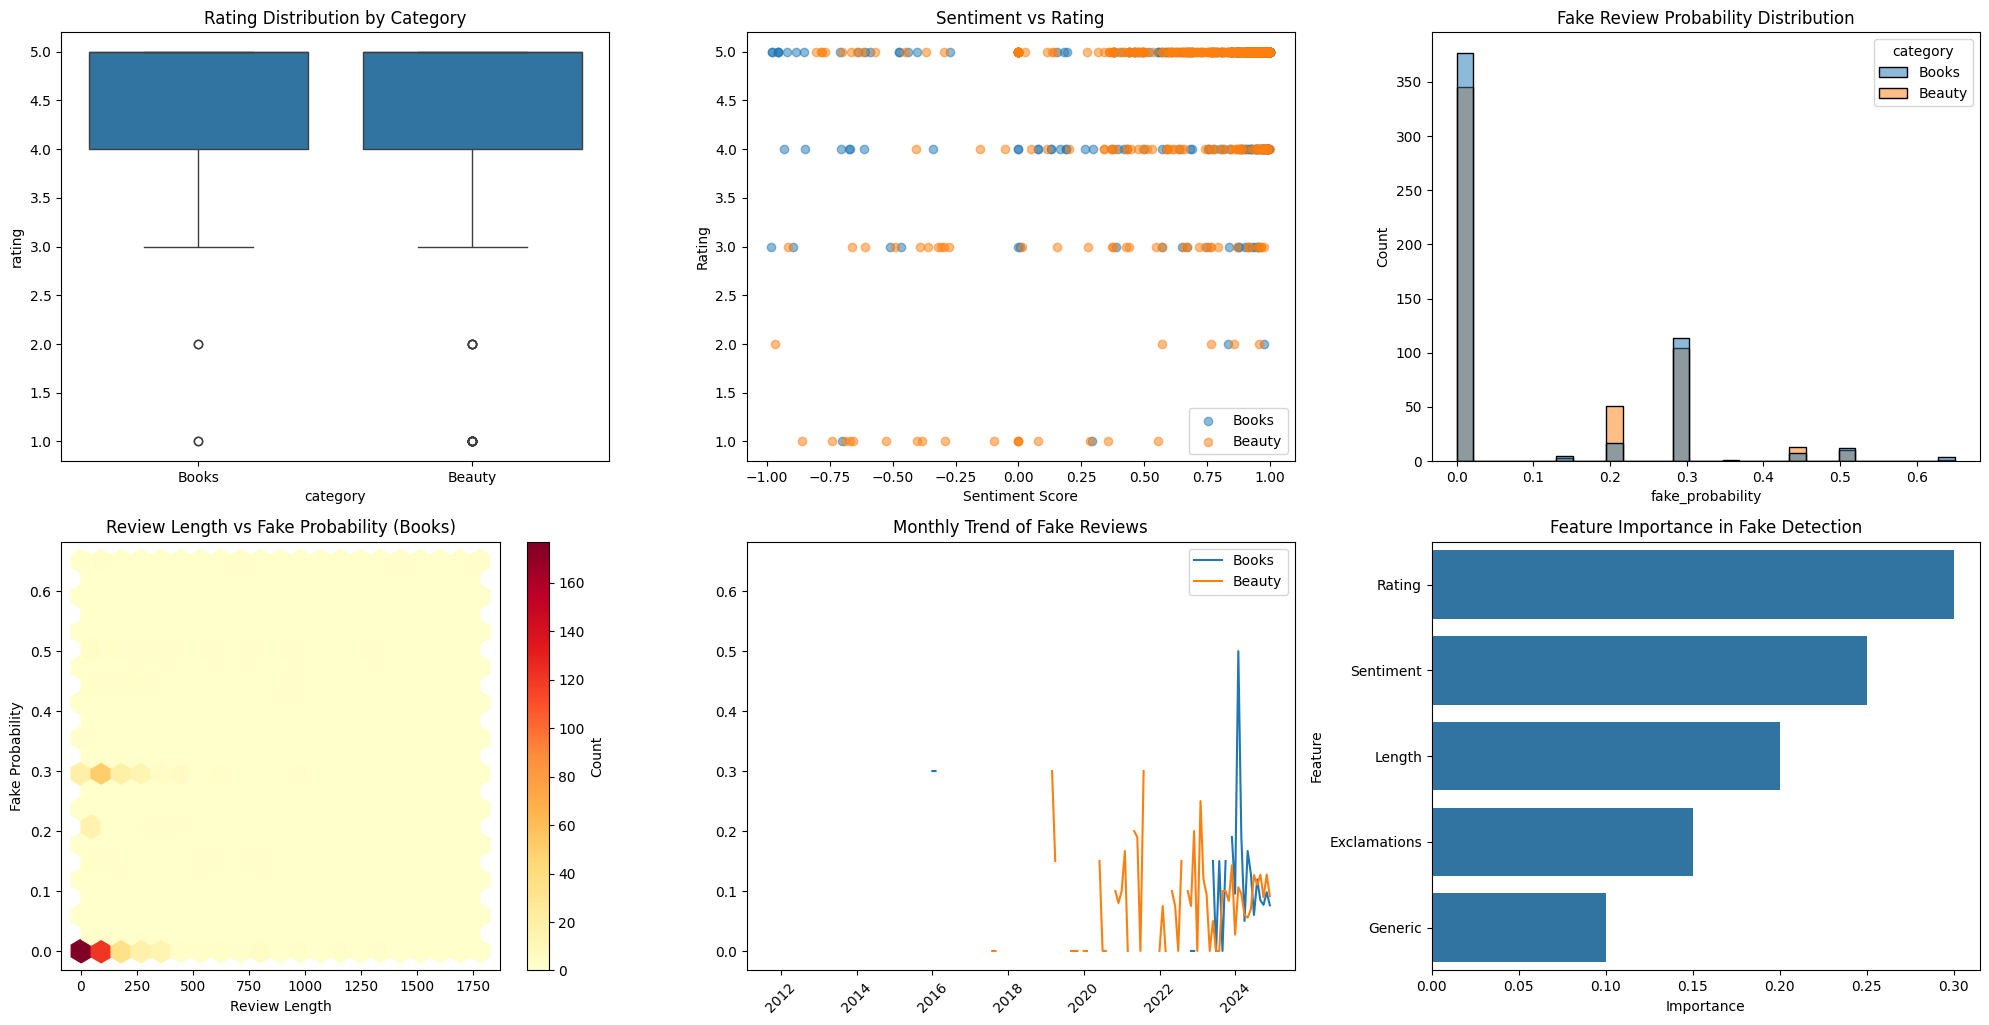

In [24]:
plot_enhanced_visualizations(books_df, beauty_df)

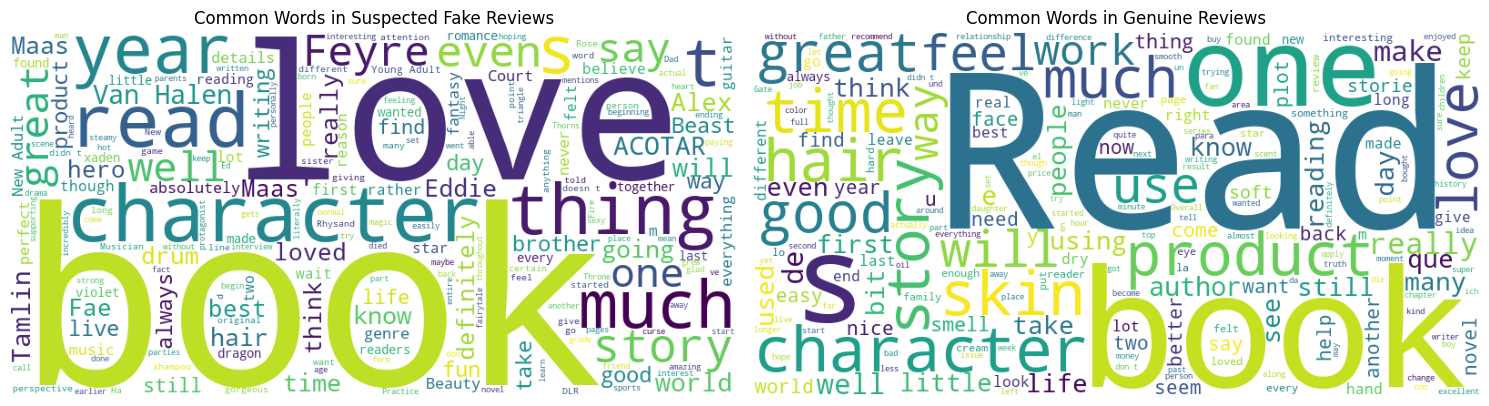

In [25]:
generate_wordclouds(books_df, beauty_df)

In [26]:
impact_metrics = analyze_fake_review_impact()


=== Fake Review Impact Analysis ===
Books rating inflation due to fake reviews: 0.38 stars
Beauty rating inflation due to fake reviews: 0.55 stars
Percentage of fake reviews in Books: 0.7%
Percentage of fake reviews in Beauty: 0.2%


In [27]:
def save_results(books_df, beauty_df, impact_metrics):
    results = {
        'books_total_reviews': len(books_df),
        'beauty_total_reviews': len(beauty_df),
        'books_avg_rating': books_df['rating'].mean(),
        'beauty_avg_rating': beauty_df['rating'].mean(),
        'books_suspected_fake': (books_df['fake_probability'] > 0.5).mean(),
        'beauty_suspected_fake': (beauty_df['fake_probability'] > 0.5).mean(),
        'books_rating_inflation': impact_metrics['books_rating_inflation'],
        'beauty_rating_inflation': impact_metrics['beauty_rating_inflation'],
        'books_fake_percent': impact_metrics['books_fake_percent'],
        'beauty_fake_percent': impact_metrics['beauty_fake_percent']
    }
    
    pd.DataFrame([results]).to_csv('analysis_results.csv', index=False)


In [28]:
books_df['fake_probability'] = identify_fake_reviews(books_df)

In [29]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

In [30]:
def extract_features(df):
    if 'content' not in df.columns:
        df['content'] = df['review_text']  # Adjust column name if needed
    
    df['review_length'] = df['content'].str.len()
    df['exclamation_count'] = df['content'].str.count('!')
    
    df['sentiment_score'] = df['content'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    
    df['caps_ratio'] = df['content'].apply(
        lambda x: sum(1 for c in str(x) if c.isupper()) / len(str(x)) if len(str(x)) > 0 else 0
    )
    
    df['repeated_chars'] = df['content'].apply(
        lambda x: len(re.findall(r'(.)\1{2,}', str(x))) / len(str(x)) if len(str(x)) > 0 else 0
    )
    
    generic_phrases = ['amazing', 'great', 'awesome', 'best', 'love it', 'excellent']
    df['generic_phrases'] = df['content'].apply(
        lambda x: sum(1 for phrase in generic_phrases if phrase in str(x).lower()) / len(str(x)) if len(str(x)) > 0 else 0
    )
    
    return df

In [34]:
import re 

In [35]:
def train_fake_review_detector(df):
    df = extract_features(df)
    
    feature_columns = ['review_length', 'exclamation_count', 'sentiment_score', 
                      'caps_ratio', 'repeated_chars', 'generic_phrases']
    X = df[feature_columns]
    y = df['fake_probability'] > 0.35
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    clf = SVC(kernel='linear', random_state=0)
    clf.fit(X_train_scaled, y_train)
    
    y_pred = clf.predict(X_test_scaled)
    print("=== SVM Classifier ===")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(classification_report(y_test, y_pred))
    
    return clf, scaler

In [32]:
def predict_fake_reviews(df, clf, scaler):
    df = extract_features(df)
    
    feature_columns = ['review_length', 'exclamation_count', 'sentiment_score', 
                      'caps_ratio', 'repeated_chars', 'generic_phrases']
    X = df[feature_columns]
    X_scaled = scaler.transform(X)
    
    df['predicted_fake'] = clf.predict(X_scaled)
    return df

In [36]:
combined_df = pd.concat([books_df, beauty_df])
clf, scaler = train_fake_review_detector(combined_df)

=== SVM Classifier ===
Accuracy: 0.96
              precision    recall  f1-score   support

       False       0.96      0.99      0.98       199
        True       0.86      0.43      0.57        14

    accuracy                           0.96       213
   macro avg       0.91      0.71      0.77       213
weighted avg       0.95      0.96      0.95       213



In [ ]:
books_df = predict_fake_reviews(books_df, clf, scaler)
beauty_df = predict_fake_reviews(beauty_df, clf, scaler)

In [ ]:
def print_category_stats(df, category):
    print(f"\n=== {category} Category Statistics ===")
    print(f"Total reviews: {len(df)}")
    print(f"Predicted fake reviews: {df['predicted_fake'].sum()}")
    print(f"Fake review percentage: {(df['predicted_fake'].sum() / len(df)) * 100:.2f}%")
    print(f"Average rating of predicted fake reviews: {df[df['predicted_fake'] == 1]['rating'].mean():.2f}")
    print(f"Average rating of predicted genuine reviews: {df[df['predicted_fake'] == 0]['rating'].mean():.2f}")

In [ ]:
print_category_stats(books_df, "Books")
print_category_stats(beauty_df, "Beauty")


=== Books Category Statistics ===
Total reviews: 537
Predicted fake reviews: 105
Fake review percentage: 19.55%
Average rating of predicted fake reviews: 4.58
Average rating of predicted genuine reviews: 4.64

=== Beauty Category Statistics ===
Total reviews: 527
Predicted fake reviews: 55
Fake review percentage: 10.44%
Average rating of predicted fake reviews: 4.75
Average rating of predicted genuine reviews: 4.41


In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
def plot_confusion_matrix(df, category):
    plt.figure(figsize=(6, 5))
    cm = confusion_matrix(df['fake_probability'] > 0.2, df['predicted_fake'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Genuine', 'Fake'], yticklabels=['Genuine', 'Fake'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix: {category}')
    plt.show()

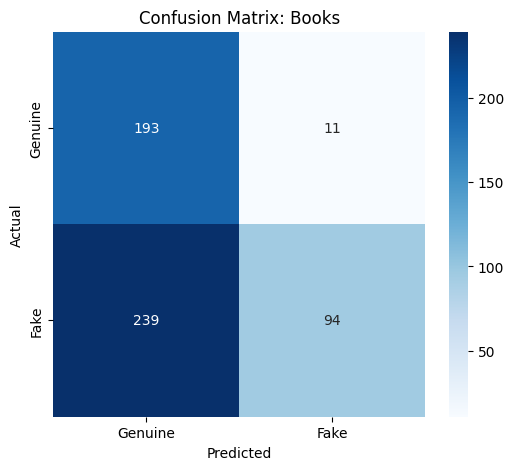

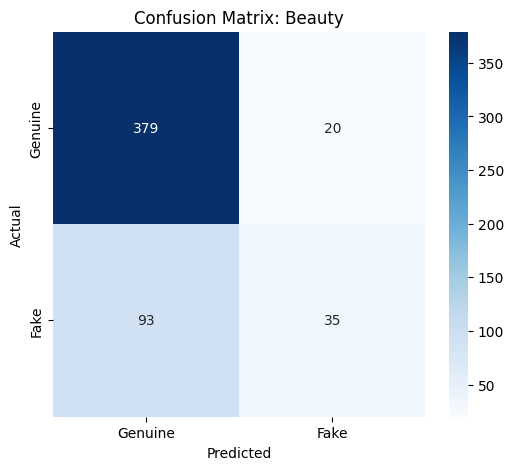

In [ ]:

plot_confusion_matrix(books_df, "Books")
plot_confusion_matrix(beauty_df, "Beauty")